In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import copy
import cv2
from data_load import DataLoad

In [2]:
dl = DataLoad()
(ds_train, ds_test), ds_info = dl.load_tfds()

In [3]:
import os
cam_model_path = os.getenv("HOME")+'/aiffel/class_activation_map/cam_model.h5'
cam_best_model_path = os.getenv("HOME")+"/project/Going_deeper/GD_gradCAM/best_checkpoint.h5"
cam_model = tf.keras.models.load_model(filepath=cam_best_model_path)

In [4]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

<class 'numpy.int64'>


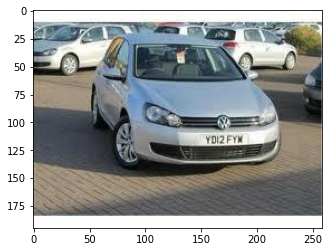

In [5]:
item = get_one(ds_test)
print(type(item['label']))
plt.imshow(item['image'])

### CAM

In [15]:
def generate_cam(model, item):
    #기존 데이터에 영향을 안주기위해 완전히 새로운 객체를 할당(?)하기
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    #이미지 resize, 정규화 후 label이랑 같이 리턴
    img_tensor, class_idx = dl.normalize_and_resize_img(item)
    
    #학습 모델에서 원하는 레이어의 output을 얻기 위해 모델의 input과 output을 새롭게 정의한다.
    #자세한 부분은 아래에서 확인하자
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져온다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W*f를 통해 class 별 activation map을 계산한다.
        cam_image += w * conv_outputs[:,:,i]
        
    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

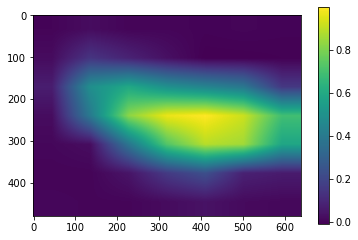

In [16]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.colorbar()

In [17]:
#원본이미지랑 합쳐보기
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    cam_image_int = np.uint8(255 * src1)
    heatmap = cv2.applyColorMap(cam_image_int, cv2.COLORMAP_JET)
    merged_image = cv2.addWeighted(heatmap, alpha, src2, beta, 0.0)
    return merged_image

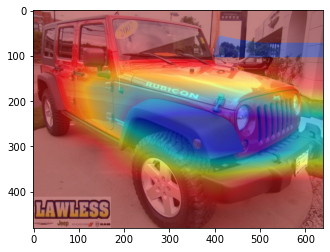

In [18]:
origin_image = item['image'].astype(np.uint8)
blended_image = visualize_cam_on_image(cam_image, origin_image)
plt.imshow(blended_image)

### Grad-CAM

12


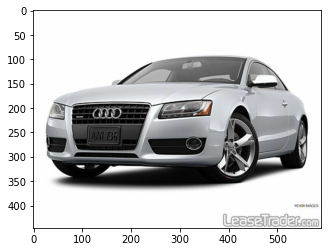

In [6]:
#새로운 이미지 뽑기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [7]:
np.shape(item["image"])

(446, 590, 3)

In [8]:
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [9]:
cam_model.inputs

[<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>]

In [10]:
cam_model.get_layer("conv5_block3_out").output

<tf.Tensor 'conv5_block3_out/Relu:0' shape=(None, 7, 7, 2048) dtype=float32>

In [11]:
cam_model.outputs

[<tf.Tensor 'dense/Softmax:0' shape=(None, 196) dtype=float32>]

In [19]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item["image"].shape[1]
    height = item["image"].shape[0]
    img_tensor, class_idx = dl.normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        print(type(pred))
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용)
        output=conv_output[0] #원하는 layer의 output을 얻는다.
        grad_val = tape.gradient(loss, conv_output)[0] #예측값에 따른 layer의 gradient를 얻는다.
    
    weights = np.mean(grad_val, axis=(0,1)) #gradient의 GAP로 class별 weight를 구한다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻는다.
        grad_cam_image += w * output[:,:,k]
    
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


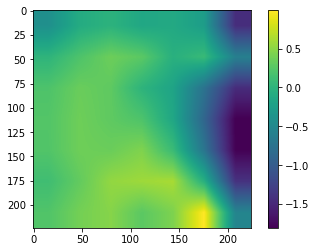

In [20]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.colorbar()

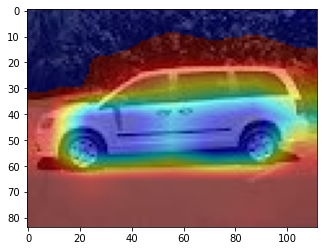

In [14]:
origin_image = item['image'].astype(np.uint8)
blended_image = visualize_cam_on_image(grad_cam_image, origin_image)
plt.imshow(blended_image)

In [15]:
np.shape(grad_cam_image)

(84, 112)

In [16]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    
    rotated_rect = cv2.minAreaRect(cnt)
    
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [17]:
def rect_to_minmax(rect, image):
    bbox=[
        rect[:,1].min()/float(image.shape[0]),
        rect[:,0].min()/float(image.shape[1]),
        rect[:,1].max()/float(image.shape[0]),
        rect[:,0].max()/float(image.shape[1])
    ]
    return bbox

In [18]:
def get_iou(gt_bbox, pred_bbox):
    iou = None
    y_min = max(gt_bbox[0], pred_bbox[0])
    x_min= max(gt_bbox[1], pred_bbox[1])
    y_max = min(gt_bbox[2], pred_bbox[2])
    x_max = min(gt_bbox[3], pred_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    gt_bboxArea = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    pred_bboxArea = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    iou = interArea / float(gt_bboxArea + pred_bboxArea - interArea)

    return iou

In [19]:
image = copy.deepcopy(item["image"])
rect = get_bbox(cam_image)
rect

array([[135,  92],
       [  0,  92],
       [  0,  23],
       [135,  23]])

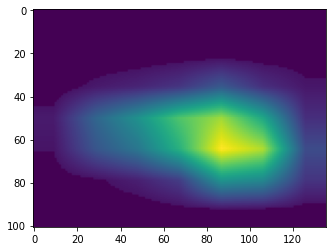

In [20]:
plt.imshow(cam_image)

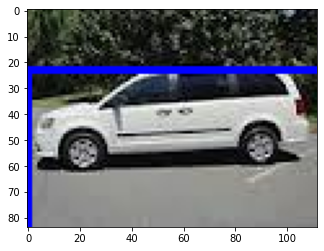

In [21]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [22]:
pred_bbox = rect_to_minmax(rect, item["image"])
get_iou(pred_bbox, item["bbox"])

0.4960671016865347